# <font color = salmon> Multiple Agents - Single Function (ie Tool))

## <font color = grey> Replicating the Manual Process seen in Notebook M-5
#### <font color = grey> Conda Env: <font color = pink> 20240716_AutoGen_WIP

---

### <font color = Olive> Admin

#### <font color = darkgrey> Imports

In [15]:
############################## Imports & Display Options ###############################################

import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
import os
import autogen


from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

########################### Set Base Directory #########################################################

# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

################################# Set Working Directory ##############################################

# target_directory = os.path.join(base_dir, '/mnt/efs-w210-capstone/200015/12.Agents_TOI_AutoGen')

target_directory = os.path.join(base_dir, '/home/ubuntu/efs-w210-capstone-ebs/12.Agents_TOI_AutoGen/20240629_06.Tool_Use/')

# efs-w210-capstone/200015/12.Agents_TOI_AutoGen/20240629_02.Multi-Agent Collaboration (>3 Agents)

# # Change to the target directory
os.chdir(target_directory)
print(f"Changed directory to: {os.getcwd()}")

################################### Set API Keys #####################################################

os.environ['OPENAI_API_KEY'] = 'sk-proj-iQtcgUJOOf4n53Bs6uyqT3BlbkFJnEIqUeEwXjbjVMcDVqiz'

################################# Check Agent Setup - Sample ##########################################

from autogen import ConversableAgent

config_list = [
    {"model": "gpt-4o", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4-turbo-preview", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4-0314", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt4", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4-32k", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4-32k-0314", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"},
    {"model": "gpt-4-32k-v0314", "api_key": os.environ.get("OPENAI_API_KEY"), "api_type": "openai"}
]

llm_config={
    # "request_timeout": 600,
    "seed": 42,
    "config_list": config_list,
    "temperature": 0
}

# agent = ConversableAgent(
#     "chatbot",
#     llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ.get("OPENAI_API_KEY")}]},
#     code_execution_config=False,  # Turn off code execution, by default it is off.
#     function_map=None,  # No registered functions, by default it is None.
#     human_input_mode="NEVER",  # Never ask for human input.
# )

# reply = agent.generate_reply(messages=[{"content": "Tell me a joke.", "role": "user"}])
# print(reply)


################################# Tools Setup ##########################################

os.environ["SERPAPI_API_KEY"] = "6d6dd5330f69328aabc9a71bfd69477819748a56"


###################################### REFERENCE ONLY --> DOES NOT WORK FOR SINGLE CHATS #############

# for i, chat_res in enumerate(chat_results):
#     print(f"*****{i}th chat*******:")
#     print(chat_res.summary)
#     print("Human input in the middle:", chat_res.human_input)
#     print("Conversation cost: ", chat_res.cost)
#     if i == 1:
#         assert (
#             len(chat_res.chat_history) == 4
#         ), f"The chat history should contain at most 4 messages because max_turns is set to 2 in the {i}-th chat."
#     print("\n\n")

# # Get the chat history.
# import pprint

# pprint.pprint(reply.chat_history)

# # Get the cost of the chat.
# pprint.pprint(reply.cost)

Base directory set to: /home/sagemaker-user
Changed directory to: /home/ubuntu/efs-w210-capstone-ebs/12.Agents_TOI_AutoGen/20240629_06.Tool_Use


In [16]:
import autogen
from typing import Literal
from pydantic import BaseModel, Field
from typing_extensions import Annotated
import requests
from autogen.cache import Cache

---

## <font color = coral> Roles and Setup

In [17]:
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    code_execution_config={
        "work_dir": "group",
        "use_docker": False,},
    max_consecutive_auto_reply=10,
    system_message="""Reply TERMINATE if the task been solved at full satisfaction. 
    Otherwise, reply CONTINUE or the reason why the task is not solved yet. """,

)

In [18]:
log_data_retriever = autogen.AssistantAgent(
    name="chatbot",
    # system_message="For weather forecasting tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    system_message="For all tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

In [19]:
log_data_writer = autogen.AssistantAgent(
    name="weather_data_writer",
    system_message="""

    You are a creative writer and your job is to take the data extracted by log_data_retriever and 
    summarize the content in a email with subject header and body. Please only return if the response is
    an anomolous value or not.
    
    """,
    llm_config=llm_config,
    
)

---

## <font color = coral> Admin Note: Flask App

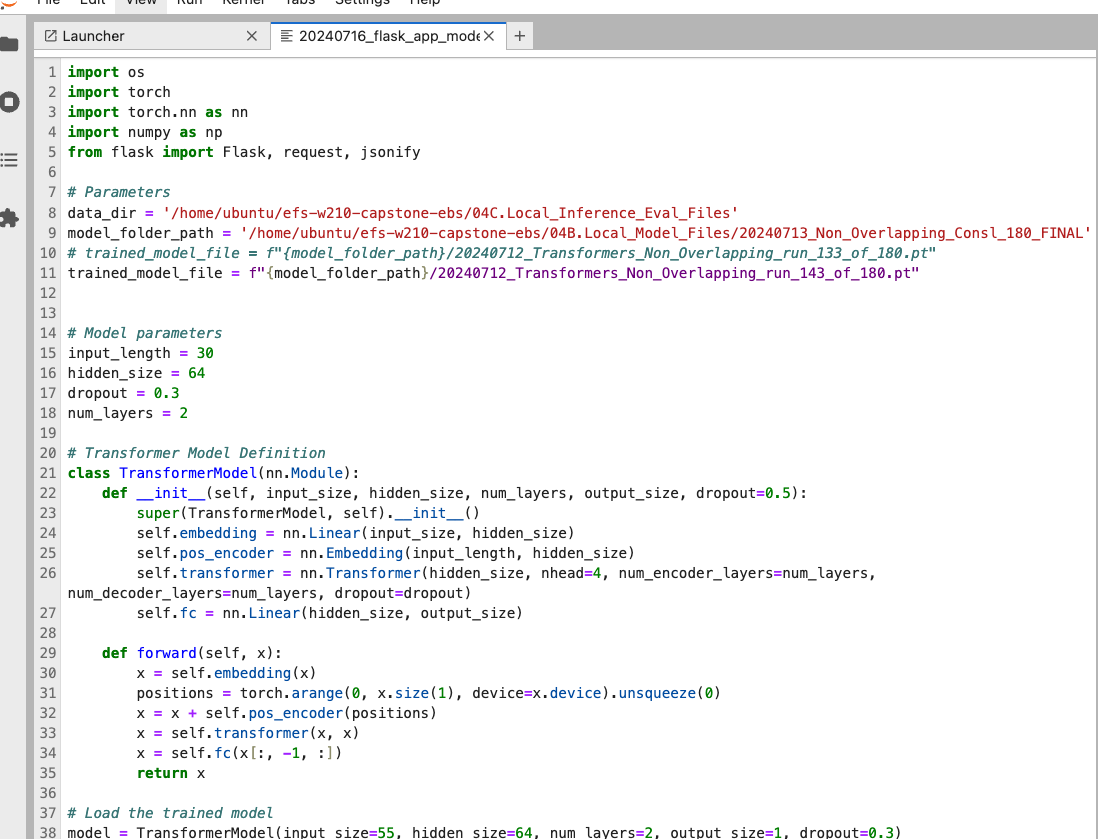

---

## <font color = coral> Function Definition and Registration --> get_sensor_data

In [27]:
import requests
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from datetime import datetime
from typing import Union

# Parameters
data_dir = '/home/ubuntu/efs-w210-capstone-ebs/04A.Local_Data_Files'
save_dir = '/home/ubuntu/efs-w210-capstone-ebs/04C.Local_Inference_Eval_Files'
file_prefix = "06.20240714_062624_non_overlap_full_test"  # Replace with your actual file prefix
start_time = '2005-11-08 18:50:00'  # seq 11624
num_tests = 130

def prepare_and_send_data_to_agent(data_dir, save_dir, file_prefix, start_time, num_tests):
    # Load the test data
    X_test = np.load(f"{data_dir}/{file_prefix}_X_test.npy")
    y_test = np.load(f"{data_dir}/{file_prefix}_y_test.npy")

    # Load the original parquet file with sequence mapping
    input_file = f"{data_dir}/03.20240715_143154_orig_input_w_seq_info_FINAL.parquet"
    original_df = pd.read_parquet(input_file)

    # Ensure Seq_Num is integer for proper merging
    original_df['Seq_Num'] = original_df['Seq_Num'].astype(int)

    # Filter the test dataset based on the specified start time
    start_seq_num = original_df[(original_df['Train_Test'] == 'Test') & (original_df['time_start'] == start_time)]['Seq_Num'].values[0]

    # Define the number of records for each test run (20 source + 2 gap + 1 prediction period = 23 records)
    num_records_per_test = 33

    # Calculate the maximum end seq_num based on the dataset
    max_end_seq_num = original_df[original_df['Train_Test'] == 'Test']['Seq_Num'].max()

    # Calculate expected end seq_num based on user input
    expected_end_seq_num = start_seq_num + num_tests * num_records_per_test - 1

    # Check if the user-specified number of runs exceeds the maximum allowed runs
    if expected_end_seq_num > max_end_seq_num:
        max_allowed_runs = (max_end_seq_num - start_seq_num + 1) // num_records_per_test
        num_tests = max_allowed_runs
        expected_end_seq_num = start_seq_num + num_tests * num_records_per_test - 1

    # Calculate the correct start and end sequence numbers for X_test and y_test
    start_index_x_test = (start_seq_num - original_df[original_df['Train_Test'] == 'Test']['Seq_Num'].min()) // num_records_per_test
    end_index_x_test = start_index_x_test + num_tests

    # Ensure the end sequence number does not exceed the length of the test data
    if end_index_x_test > len(X_test):
        end_index_x_test = len(X_test)

    # Prepare the data for the specified number of test runs
    X_test_limited = X_test[start_index_x_test:end_index_x_test]
    y_test_limited = y_test[start_index_x_test:end_index_x_test]

    # Prepare the data for the request
    data = {'X_test': X_test_limited.tolist()}

    # Send a request to the server
    response = requests.post('http://0.0.0.0:5000/predict', json=data)
    response_data = response.json()

    # Process the response
    predictions = np.array(response_data['predictions']).flatten()

    # Create DataFrame for tracking and merging with additional information
    tracking_data = []

    for i in range(num_tests):
        total_seq_start = start_seq_num + i * num_records_per_test
        total_seq_end = total_seq_start + num_records_per_test - 1
        source_seq_start = total_seq_start
        source_seq_end = source_seq_start + 30 - 1
        gap_seq_start = source_seq_end + 1
        gap_seq_end = gap_seq_start + 1
        prediction_seq_start = total_seq_end - 1
        prediction_seq_end = total_seq_end
        
        tracking_data.append([
            total_seq_start, total_seq_end, source_seq_start, source_seq_end,
            gap_seq_start, gap_seq_end, prediction_seq_start, prediction_seq_end,
            predictions[i],  # Corrected to take the i-th prediction
            y_test_limited[i],  # Corresponding actual label
            str(original_df[original_df['Seq_Num'] == source_seq_start]['time_start'].values[0])  # Convert timestamp to string
        ])

    tracking_df = pd.DataFrame(tracking_data, columns=[
        "Total_Seq_Start", "Total_Seq_End", "Source_Seq_Start", "Source_Seq_End",
        "Gap_Seq_Start", "Gap_Seq_End", "Prediction_Seq_Start", "Prediction_Seq_End",
        "Predicted", "Actual", "time_start"
    ])

    # Define the timestamp
    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

    # Save the consolidated DataFrame to the specified location
    final_file = f"{save_dir}/03B.{timestamp}_agent1_non_overlap_model2_consl.csv"
    tracking_df.to_csv(final_file, index=False)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test_limited, predictions, labels=[0, 1])
    precision = precision_score(y_test_limited, predictions, zero_division=0)
    recall = recall_score(y_test_limited, predictions, zero_division=0)
    accuracy = accuracy_score(y_test_limited, predictions)
    f1 = f1_score(y_test_limited, predictions, zero_division=0)

    # Check if the confusion matrix has the expected shape
    if conf_matrix.size == 4:
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        # Handle cases with fewer than two classes in the confusion matrix
        tn = conf_matrix[0, 0] if conf_matrix.shape[0] > 0 else 0
        fp = conf_matrix[0, 1] if conf_matrix.shape[1] > 1 else 0
        fn = conf_matrix[1, 0] if conf_matrix.shape[0] > 1 else 0
        tp = conf_matrix[1, 1] if conf_matrix.shape[1] > 1 else 0

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Class 1)', 'Recall (Class 1)', 'F1 Score', 'True Positives', 'False Positives', 'True Negatives', 'False Negatives'],
        'Value': [accuracy, precision, recall, f1, tp, fp, tn, fn]
    })

    return tracking_df, metrics_df
    # return metrics_df

# Agent Function
@user_proxy.register_for_execution()
@log_data_retriever.register_for_llm(description="Retrieve sensor data from Flask API")
def get_sensor_data() -> Union[dict, str]:
    tracking_df, metrics_df = prepare_and_send_data_to_agent(data_dir, save_dir, file_prefix, start_time, num_tests)
    
    # Convert DataFrames to dictionary and ensure all timestamps are converted to strings
    tracking_data = tracking_df.applymap(lambda x: str(x) if isinstance(x, pd.Timestamp) else x).to_dict()
    metrics_data = metrics_df.to_dict()

    # Prepare response
    response = {
        'tracking_data': tracking_data,
        'metrics': metrics_data
    }
    return response

---

In [28]:
log_data_retriever.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Retrieve sensor data from Flask API',
   'name': 'get_sensor_data',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}}]

---

In [29]:
assert user_proxy.function_map["get_sensor_data"]._origin == get_sensor_data

---

## <font color = coral> Inference

#### <font color = teal> Setup

In [30]:
task = """

Your task is to simply run the only function you have access to and return the coontent generated

"""

In [31]:
# task = """

# This is a anomaly detection task. Please return only the 'anomaly' and 'anomaly_score' values from the 
# flask API endpoint. In case the 'anomaly' value = 1, then flag that as an anomaly. 
# Please save both the anomaly and anomaly_score values and include in final email from weather_data_writer

# """

In [32]:
groupchat = autogen.GroupChat(agents=[user_proxy, log_data_retriever, log_data_writer], \
                              messages=[], max_round=10)

manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

# <font color = tomato> Use Case 1: Default Parameters (Hardcoded)
### <font color = blue> To get the basic Agent API working

In [33]:
with Cache.disk() as cache:
    # start the conversation
    res = user_proxy.initiate_chat(
        manager, message=task, summary_method="reflection_with_llm", cache=cache, llm_config=llm_config
    )

user_proxy (to chat_manager):



Your task is to simply run the only function you have access to and return the coontent generated



--------------------------------------------------------------------------------

Next speaker: chatbot

chatbot (to chat_manager):

***** Suggested tool call (call_SsiD5RmoCveBfAVbr3Dt0XPR): get_sensor_data *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

Next speaker: user_proxy


>>>>>>>> EXECUTING FUNCTION get_sensor_data...
user_proxy (to chat_manager):

user_proxy (to chat_manager):

***** Response from calling tool (call_SsiD5RmoCveBfAVbr3Dt0XPR) *****
{"tracking_data": {"Total_Seq_Start": {"0": 11624, "1": 11657, "2": 11690, "3": 11723, "4": 11756, "5": 11789, "6": 11822, "7": 11855, "8": 11888, "9": 11921, "10": 11954, "11": 11987, "12": 12020, "13": 12053, "14": 12086, "15": 12119, "16": 12152, "17": 12185, "18